# Common grid bias-adjustment quality control

Quality control the bias-adjusted common grid data!

In [2]:
# parameters cell
working_dir = "/import/beegfs/CMIP6/crstephenson"
sim_dir = "/import/beegfs/CMIP6/arctic-cmip6/regrid"
adj_dir = "/import/beegfs/CMIP6/crstephenson/bias_adjust/netcdf"
ref_dir = "/import/beegfs/CMIP6/arctic-cmip6/era5/daily_regrid"

In [2]:
from datetime import datetime
from itertools import product
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client
import dask
from dask_jobqueue import SLURMCluster
from config import *
from bias_adjust import generate_cmip6_fp
from generate_doy_summaries import get_sim_fps
from slurm import get_directories
from luts import sim_ref_var_lu

var_ids = var_ids.split()
models = models.split()
scenarios = scenarios.split()

print(var_ids)
print(models)
print(scenarios)

# dask.config.set({"array.chunk-size": "64 MB"})

working_dir = Path(working_dir)
sim_dir = Path(sim_dir)
ref_dir = Path(ref_dir)

output_dir, adj_dir = get_directories(working_dir, output_dir_name)
log_dir = "."

# Years for ERA5 reference data
ref_years = list(range(1981, 2022 + 1))

historical_years = list(range(1951, 2014 + 1))
projected_years = list(range(2015, 2100 + 1))

years = {
    "historical": historical_years,
    "ssp126": projected_years,
    "ssp245": projected_years,
    "ssp370": projected_years,
    "ssp585": projected_years,
}

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from config import *


working_dir = Path(working_dir)
sim_dir = Path(sim_dir)
ref_dir = Path(ref_dir)
doy_summary_dir = working_dir.joinpath(
    output_dir_name, qc_dir_name, doy_summary_dir_name
)

## Verify long term day-of-year summaries

Compare the day-of-year (DOY) values between reference data, unadjusted model data, and adjusted model data. 

We have computed DOY summaries for these data which consist of minimum, mean, and maximum values taken over all years.
There are many possible ways to analyze these summaries to assess the quality of the adjusted data. 

* Entire datasets can be compared using simple deltas and subequent summaries thereof, and with distance metrics like RMSE 
* pixel DOY "time" series can be assessed using line charts

The minimum and maximum differences (deltas) between DOY summary statistics of adjusted and unadjusted data can help us identify extremes / over-corrections. For example, we can evaluate the largest adjustments for each pixel by computing the maximum deltas between adjusted and unadjusted data DOY maximums, and the minimum deltas between DOY minimums. Means of these corresponding deltas show us the average adjustments at the extremes.

Open the DOY summaries for the historical precip simulations of a single model:

In [7]:
def doy_summary_maps(ds):
    for model in models:
        for scenario in scenarios:
            fig, ax = plt.subplots(2, 2, figsize=(16, 6))
            # Show side-by-side charts for two days of the year.
            y_axis = 0
            for day_of_year in [1, 180]:
                lon_slice = slice(0, 360)
                lat_slice = slice(0, 90)
                print(ds)
                params = {
                    "model": model,
                    "scenario": scenario,
                    "dayofyear": day_of_year,
                    "lat": lat_slice,
                    "lon": lon_slice,
                }
                sim_map = ds.sel(kind="sim", **params)["max"]
                adj_map = ds.sel(kind="adj", **params)["max"]
                sim_map.plot(ax=ax[y_axis][0])
                adj_map.plot(ax=ax[y_axis][1])
                y_axis += 1
            plt.tight_layout()

for var_id in var_ids:
    ds = xr.open_mfdataset(
        list(doy_summary_dir.glob(f"{var_id}_*.nc"))
    ) #.squeeze()
    doy_summary_maps(ds)

<xarray.Dataset>
Dimensions:    (lat: 43, lon: 288, dayofyear: 365, kind: 2)
Coordinates:
  * lat        (lat) float64 50.42 51.36 52.3 53.25 ... 87.17 88.12 89.06 90.0
  * lon        (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * kind       (kind) object 'adj' 'sim'
    scenario   <U10 'historical'
    var_id     <U2 'pr'
    model      <U13 'CNRM-CM6-1-HR'
Data variables:
    min        (kind, dayofyear, lat, lon) float64 dask.array<chunksize=(1, 365, 43, 288), meta=np.ndarray>
    mean       (kind, dayofyear, lat, lon) float64 dask.array<chunksize=(1, 365, 43, 288), meta=np.ndarray>
    max        (kind, dayofyear, lat, lon) float64 dask.array<chunksize=(1, 365, 43, 288), meta=np.ndarray>

We can draw the following conclusions:

* The largest within-day-of-year difference in precipitation between adjusted and unadjusted data is ~1.5 m! That is, there is some value in the adjusted data that is ~1.5 m larger than some value in the unadjusted data for the same day-of-year. (max difference between day-of-year maximums)
* The smallest within-day-of-year difference in precipitation between adjusted and unadjusted data is about -0.2 m (i.e. min difference between day-of-year minimums)
* mean difference between day-of-year minimums is ~0.01 m
* mean difference between day-of-year maximums is ~0.1 m

This plot seems like a good start for plotting for each subdataset. Make a function and iterate to plot:

What we are trying to get after is adjustments that have gone too far. An example of this is mean adjusted DOY dataset being 20-30x larger than modeled data.

For each model, scenario, variable, and day-of-year summary statistic (min, mean, max) we can evaluate the differences between modeled and adjusted data. 

In [25]:
for var_id in var_ids:
    ds = xr.open_mfdataset(
        list(doy_summary_dir.glob(f"{var_id}_*.nc"))
    ).squeeze()
    delta_ds = ds.sel(kind="adj") - ds.sel(kind="sim")
    for scenario in scenarios:
        plt.figure(figsize=(12, 4))
        delta_ds.sel(scenario=scenario)["max"].max(dim="lat").max(dim="lon").plot()
        delta_ds.sel(scenario=scenario)["min"].min(dim="lat").min(dim="lon").plot()
        plt.title(f"Variable: {ds.var_id.values}, Scenario: {scenario}")
        plt.legend()
        plt.show()

<xarray.DataArray 'mean' (lat: 1, lon: 1)>
array([[0.05055845]])
Coordinates:
  * lat       (lat) float64 54.19
  * lon       (lon) float64 138.8
    scenario  <U10 'historical'
    var_id    <U2 'pr'
    model     <U6 'MIROC6'

So it looks like 54.19°N, 138.8°W is one such example of possible overcorrection. 

In [29]:
for var_id in var_ids:
    ds = xr.open_mfdataset(
        list(doy_summary_dir.glob(f"{var_id}_*.nc"))
    ).squeeze()

    for scenario in scenarios:
        delta_ds = ds.sel(kind="adj", scenario=scenario) - ds.sel(kind="sim", scenario=scenario)
        maximum_doy_deltas = delta_ds["mean"].max(dim="dayofyear").compute()
        max_delta_pixels = maximum_doy_deltas.where(
            maximum_doy_deltas == maximum_doy_deltas.max(), drop=True
        )
        max_delta_pixels
        bad_lat = max_delta_pixels.lat.values[0]
        bad_lon = max_delta_pixels.lon.values[0]

        plt.figure(figsize=(12, 4))
        ds.sel(lat=bad_lat, lon=bad_lon, scenario=scenario)["mean"].plot(x="dayofyear", hue="kind")
        plt.title(f"Variable: {ds.var_id.values}, Scenario: {scenario}")
        plt.show()

In [7]:
for var_id in var_ids:
    for model in models:
        for scenario in scenarios:
            sim_fps, adj_fps = get_sim_fps(model, scenario, var_id, years[scenario])
            sim_size = np.sum([fp.stat().st_size for fp in sim_fps]) / 1024**3
            adj_size = np.sum([fp.stat().st_size for fp in adj_fps]) / 1024**3
            print(f"{var_id}, {model}, {scenario}: {sim_size:.2f} GB, {adj_size:.2f} GB")

We will do this visually by just plotting time series for a few locations. 

We can compare this numerically for the whole datasets by using some distance metric like RMSE on the day-of-year means. We would assume the RMSE between adjusted-modeled and ERA5 reference is less than the biased-modeled and ERA5 reference.

We will just check both of these things at the same time for efficient data access.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


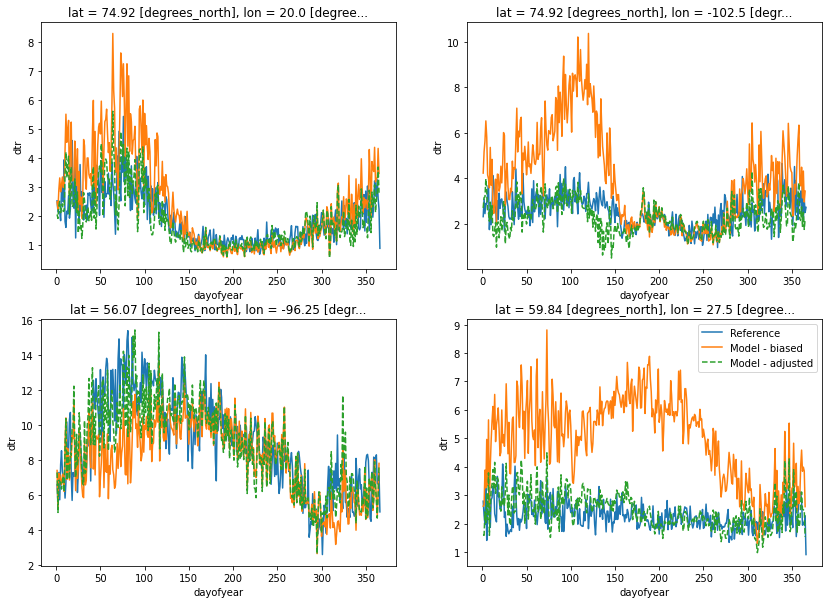

In [12]:
def get_fps(model, scenario, var_id):
    ref_var_id = sim_ref_var_lu[var_id]
    ref_fps = [
        ref_dir.joinpath(ref_var_id, ref_tmp_fn.format(ref_var_id=ref_var_id, year=year))
        for year in ref_years
    ]

    sim_fps = [
        generate_cmip6_fp(sim_dir, model, scenario, var_id, year, adjusted=False)
        for year in years[scenario]
    ]

    adj_fps = [
        generate_cmip6_fp(adj_dir, model, scenario, var_id, year, adjusted=True)
        for year in years[scenario]
    ]

    return ref_fps, sim_fps, adj_fps


@dask.delayed
def plot_single_pixel_mean_doy(
    model,
    scenario,
    var_id,
):

    ref_fps, sim_fps, adj_fps = get_fps(model, scenario, var_id)

    adj_ds = xr.open_mfdataset(adj_fps)
    ref_ds = xr.open_mfdataset(ref_fps)
    sim_ref_ds = xr.open_mfdataset(sim_fps)

    ref_var_id = sim_ref_var_lu[var_id]

    # get doy means
    ref_doy_mean = ref_ds[ref_var_id].groupby("time.dayofyear").mean()
    simref_doy_mean = sim_ref_ds[var_id].groupby("time.dayofyear").mean()
    adj_doy_mean = (
        adj_ds[var_id]
        .sel(time=slice(str(years[scenario][0]), str(years[scenario][-1])))
        .groupby("time.dayofyear")
        .mean()
    )

    # Throw out all the pixels in adj_doy_mean that are between -180.0 and 0 degrees.
    adj_doy_mean = adj_doy_mean.where((adj_doy_mean.lon >= 0) & (adj_doy_mean.lon <= 360), drop=True)

    # pick a random pixel within the domain
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    for ax in axs.flatten():
        # lat = np.random.choice(ref_ds.lat.values)
        # lon = np.random.choice(ref_ds.lon.values)
        lon = round(np.random.uniform(35, 45), 2)
        lat = round(np.random.uniform(55, 65), 2)

        ref_doy_mean.sel(lat=lat, lon=lon, method='nearest').plot(label="Reference", ax=ax)
        print(f"{lat}/{lon} {var_id} {scenario} ref_doy_mean done")
        simref_doy_mean.sel(lat=lat, lon=lon, method='nearest').plot(label="Model - biased", ax=ax)
        print(f"{lat}/{lon} {var_id} {scenario} sim_doy_mean done")
        adj_doy_mean.sel(lat=lat, lon=lon, method='nearest').plot(label="Model - adjusted", ax=ax, linestyle="--")
        print(f"{lat}/{lon} {var_id} {scenario} adj_doy_mean done") 

    plt.legend()
    plt.show()

dask_tasks = []
for var_id in var_ids:
    for scenario in scenarios:
        dask_tasks.append(plot_single_pixel_mean_doy(model, scenario, var_id))

client = Client(n_workers=4, memory_limit="8GB")
results = dask.compute(dask_tasks, scheduler="synchronous")